Choose number between two readings or take an average because most likely the true value exists between the two rather than below or above extremum values

In [18]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
import kf_book.gh_internal as gh
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt
from kf_book.gh_internal import plot_g_h_results
import matplotlib.pylab as pylab
import numpy as np
from numpy.random import randn

%matplotlib inline

In [2]:
plot_errorbars??

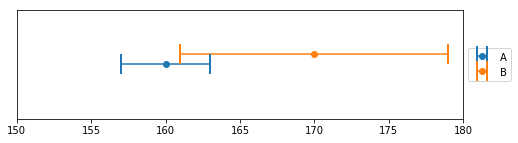

In [3]:
plot_errorbars([(160,3,'A'),(170,9,'B')], xlims=(150,180))

B appears less accurate. Instead we can opt only for A. But throwing information is bad => the intersection of B with A (part of A) could be an even better estimate.

In [4]:
gh.plot_hypothesis2()

In [5]:
gh.plot_hypothesis3()

Pay attention to the trend in the graphs. The second one most likely seems to show that the weight of the person increased. We can see that there is no horizontal line that we could draw that is inside all of the error bars.

If the prediction was always exactly the same as the measurement, it would not be capable of adding any information to the filter

In [6]:
gh.plot_estimate_chart_2()

How do we combine the two values-prediction model and measurement model? Take average just like before?

But we also know that the actual value is more likely to lie between the prediction model and sensor model's value. Should the estimate be half way between them?

Just as before since A had less error => if our prediction model has lower error then we scale the estiamte to be closer to prediction model's result

$estimate = prediction + k * (measurement - prediction)$

$k * (measurement - prediction)$ is the common region in the first bar plot between A and B

In [7]:
measurement_weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
time_step = 1
scale_factor = 0.4
initial_guess = 160.

def predict_using_gain_guess(weight, gain_rate):
    estimate = weight
    for measurement in measurement_weights:
        prediction = estimate + gain_rate * time_step
        # why not prediction - measurement??
        estimate = prediction + scale_factor * (measurement-prediction)
        print('prediction:', prediction, 'estimate:', estimate)
    

predict_using_gain_guess(initial_guess, gain_rate=1)

prediction: 161.0 estimate: 159.8
prediction: 160.8 estimate: 162.16
prediction: 163.16 estimate: 162.016
prediction: 163.016 estimate: 161.7696
prediction: 162.7696 estimate: 162.50176
prediction: 163.50176 estimate: 163.941056
prediction: 164.941056 estimate: 166.8046336
prediction: 167.8046336 estimate: 167.64278016
prediction: 168.64278016 estimate: 167.745668096
prediction: 168.745668096 estimate: 169.6474008576
prediction: 170.6474008576 estimate: 170.86844051455998
prediction: 171.86844051455998 estimate: 172.16106430873597


In [8]:
weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0  # day
scale_factor = 4.0/10

def predict_using_gain_guess(weight, gain_rate, do_print=False):     
    # store the filtered results
    estimates, predictions = [weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        prediction = weight + gain_rate * time_step

        # update filter 
        weight = prediction + scale_factor * (z - prediction)

        # save
        estimates.append(weight)
        predictions.append(prediction)
        if do_print:
            gh.print_results(estimates, prediction, weight)

    return estimates, predictions

initial_guess = 160.

estimates, predictions = predict_using_gain_guess(
    weight=initial_guess, gain_rate=1, do_print=True)

previous: 160.00, prediction: 161.00 estimate 159.80
previous: 159.80, prediction: 160.80 estimate 162.16
previous: 162.16, prediction: 163.16 estimate 162.02
previous: 162.02, prediction: 163.02 estimate 161.77
previous: 161.77, prediction: 162.77 estimate 162.50
previous: 162.50, prediction: 163.50 estimate 163.94
previous: 163.94, prediction: 164.94 estimate 166.80
previous: 166.80, prediction: 167.80 estimate 167.64
previous: 167.64, prediction: 168.64 estimate 167.75
previous: 167.75, prediction: 168.75 estimate 169.65
previous: 169.65, prediction: 170.65 estimate 170.87
previous: 170.87, prediction: 171.87 estimate 172.16


In [9]:
gh.plot_gh_results(weights, estimates, predictions) #measurement, estiamte, prediction

Note: prediction uses previous estimate as an initial point and predicts on top of that!!
The red line shows the prediction that is made from the previous day's weight. Estimate value is 40% closer to prediction

Until now we were concerned with the trend line following a similar pattern to the prediction. But rate of this trend line adjusting to the prediction line is also important. The estimates are climbing even though we tell it we are losing 1 lb a day. It just can't adjust fast enough.

Trick is to make the initial guess an estimate itself. Instead of $160+1$, $161+0.4*(158-161)$

Previously the weight gain was constant k. Instead we chage this to $new gain = old gain + k2*(measurement - predicted weight) / day$

We are adjusting the rate dynamically or we are updating the rate as well as the estimate while traversing. You now end up with two initial guess, one for weight and other for gain/loss of weight per day

In the prediction step you need to predict the next value for all variables, both weight and gain_rate

In [10]:
weight = 160.  # initial guess
gain_rate = -1.0  # initial guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # update step    
    residual = z - weight
    
    
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
gh.plot_gh_results(weights, estimates, predictions)



$g$ is the scaling we used for the measurement (weight in our example), and $h$ is the scaling for the change in measurement over time (lbs/day in our example

the state should be understood as the actual value of the system. This value is usually hidden to us. If I stepped on a scale you'd then have a measurement. We call this observable since you can directly observe this measurement. In contrast, you can never directly observe my weight, you can only measure it. Any estimation problem consists of forming an estimate of a hidden state via observable measurements

The update step is known as the measurement update. One iteration of the system propagation and measurement update is known as an epoch.

Weighting can change between measurement and the prediction.

Initialization

1. Initialize the state of the filter
2. Initialize our belief in the state

Predict

1. Use system behavior to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction

Update

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. New estimate is somewhere on the residual line



$\dot x_{0}$ = initial condition for rate of change of $x$

In [11]:
# def g_h_filter(data, x0, dx, g, h, dt):
#     # 1. Initial estimate is our initial condition
#     x_estimate = x0
#     # 2. Iterate over the measurements
#     for z in data:
#         # 3. Prediction model that starts from previous estimate
#         x_prediction = x_estimate + dx*dt
#         # 4. Estimated value
#         residual = z - z_prediction
#         x_estimate = x_prediction + residual*g
#         # 5. adjust x_dot
#         dx = dx + h* residual / dt
# book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
# data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
# plot_g_h_results(weights, data)

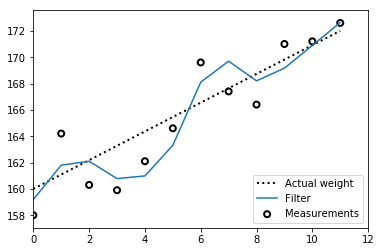

In [16]:
from kf_book.gh_internal import plot_g_h_results
import matplotlib.pylab as pylab

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)

'Ringing' means that the signal overshoots and undershoots the data in a sinusoidal type pattern

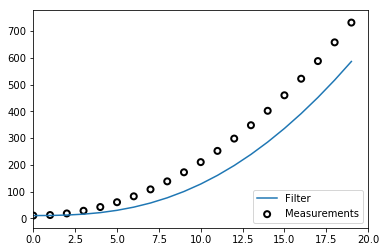

In [19]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=2.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plt.xlim([0, 20])
plot_g_h_results(measurements=zs, filtered_data=data)

In the above the measurement value is continuously increasing/ accelerating. The estimated result lags. $\ddot x$ is not taken into account. We assume $\ddot x = 0$

as $g$ is larger we more closely follow the measurement instead of the prediction

If our signal is changing a lot (quickly relative to the time step of our filter), then a large h will cause us to react to those transient changes rapidly. A smaller h will cause us to react more slowly

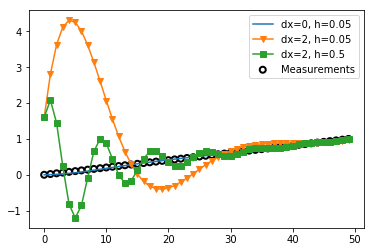

In [20]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);

In [24]:
from ipywidgets import interact
%matplotlib notebook
# my FloatSlider returns an ipywidgets.FloatSlider with
# continuous_update=False. Filtering code runs too slowly
# to instantly react to slider changes.
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0, min=-200, max=200), 
         dx=FloatSlider(value=5, min=-50, max=50), 
         g=FloatSlider(value=.1, min=.01, max=2, step=.02), 
         h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

A low and high hreshold exists for both $g$ and $h$